## Exploration of the relation between the different circle approximation of histology and MR diffusion signal

It is conveniant to talk about axons in term of radius, implicitely assuming the cylinder model.  
Therefore, it is necessary to convert the true segmented "shapes" of histology to a radius.  
This can be done in multiple ways such as smallest inscribed circle, equivalent area circle, longuest or shortest axis circle, etc...   

For MR, the various "shapes" will gives rise to some non-rotationally symmetrical mean-squared displacement.  
Under long time regime hypothesis, these signal can be matched to equivalent radius.  
This can be done with 2D Monte-Carlo simmulations and with discrete direct approximation of MSD.

We want to get an idea of how good/bad each histology circle approximation is versus the MR equivalency which is typically the comparaison target.

In [47]:
import numpy as np
import PIL as pil
import pylab as pl
from skimage.morphology import closing
import shapely as sha

In [22]:
axon_img = pil.Image.open('/data/hu_paquette/Pictures/small_axons_inside_135px_is_5um.png')
# axon_img = pil.Image.open('/data/hu_paquette/Pictures/big_axons_inside_135px_is_5um.png')

In [23]:
tmp = np.array(axon_img)

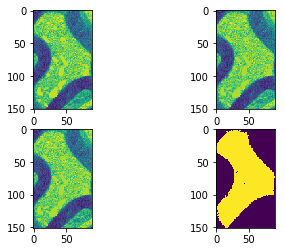

In [24]:
pl.figure()
for i in range(4):
    pl.subplot(2,2,i+1)
    pl.imshow(tmp[:,:,i])
pl.show()

In [41]:
# get clean "binary" mask
inside = tmp[:,:,3]
print('funky pixel before: {}'.format(np.prod(inside.shape) - (inside==inside.max()).sum() - (inside==inside.min()).sum()))

center = inside.min() + (inside.max() - inside.min())/2
inside[inside<=center] = inside.min()
inside[inside>center] = inside.max()
print('funky pixel after: {}'.format(np.prod(inside.shape) - (inside==inside.max()).sum() - (inside==inside.min()).sum()))


funky pixel before: 40
funky pixel after: 0


In [42]:
# element for closing morpho operation
selem = np.ones((3,3), dtype=np.bool)

In [45]:
# clean littles holes
closed = closing(inside, selem)
print('funky pixel after: {}'.format(np.prod(closed.shape) - (closed==closed.max()).sum() - (closed==closed.min()).sum()))

funky pixel after: 0


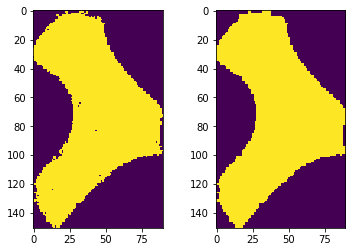

In [44]:
pl.figure()
pl.subplot(1,2,1)
pl.imshow(inside)
pl.subplot(1,2,2)
pl.imshow(closed)
pl.show()

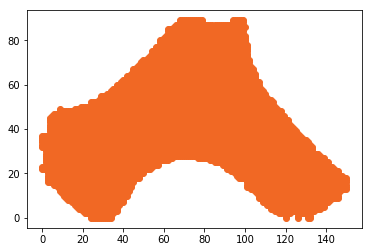

In [49]:
# convert image to 2D point for boundary definition
(x,y) = np.where(closed)

pl.figure()
pl.plot(x,y,'o', color='#f16824')
pl.show()

In [64]:
import shapely.geometry as geometry
point_collection = geometry.MultiPoint([[p[0],p[1]] for p in zip(x, y)])

In [68]:
from descartes import PolygonPatch

def plot_polygon(polygon):
    fig = pl.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    margin = .3
    x_min, y_min, x_max, y_max = polygon.bounds
    ax.set_xlim([x_min-margin, x_max+margin])
    ax.set_ylim([y_min-margin, y_max+margin])
    patch = PolygonPatch(polygon, fc='#999999',
                         ec='#000000', fill=True,
                         zorder=-1)
    ax.add_patch(patch)
    return fig

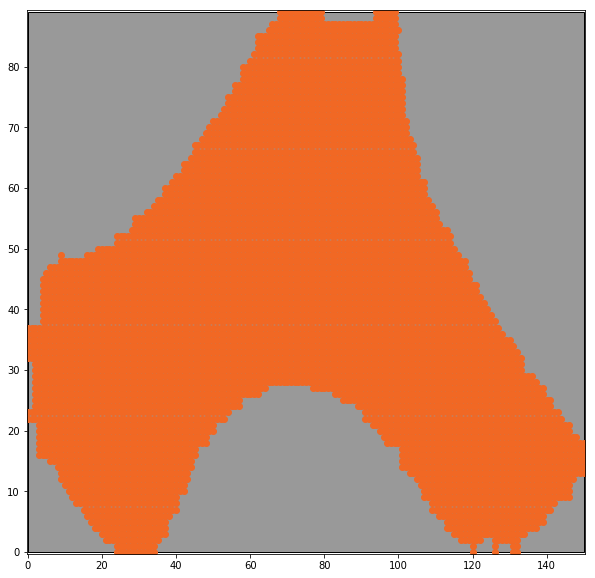

In [69]:
_ = plot_polygon(point_collection.envelope)
_ = pl.plot(x,y,'o', color='#f16824')
pl.show()

In [70]:
convex_hull_polygon = point_collection.convex_hull

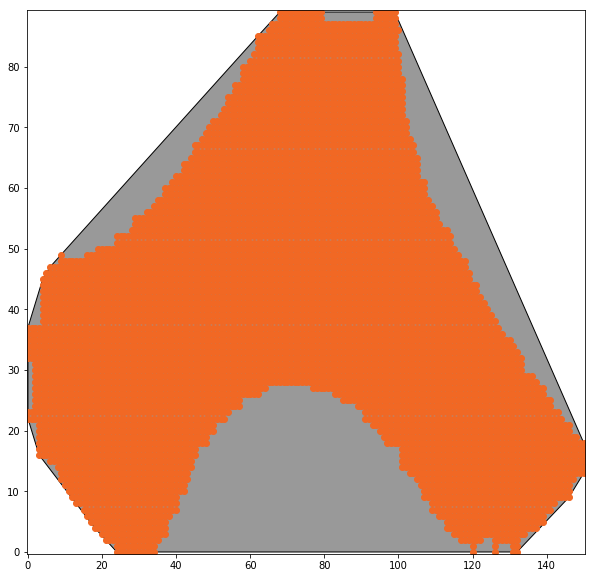

In [71]:
_ = plot_polygon(convex_hull_polygon)
_ = pl.plot(x,y,'o', color='#f16824')
pl.show()

In [91]:
# big thanks to http://blog.thehumangeo.com/2014/05/12/drawing-boundaries-in-python/
from shapely.ops import cascaded_union, polygonize
from scipy.spatial import Delaunay
import numpy as np
import math

def alpha_shape(points, alpha):
    """
    Compute the alpha shape (concave hull) of a set
    of points.
    @param points: Iterable container of points.
    @param alpha: alpha value to influence the
        gooeyness of the border. Smaller numbers
        don't fall inward as much as larger numbers.
        Too large, and you lose everything!
    """
    
    def add_edge(edges, edge_points, coords, i, j):
        """
        Add a line between the i-th and j-th points,
        if not in the list already
        """
        if (i, j) in edges or (j, i) in edges:
            # already added
            return 
        edges.add( (i, j) )
        edge_points.append(coords[ [i, j] ])
        
    coords = np.array(points)
    if coords.shape[0] < coords.shape[1]:
        coords = coords.T
    tri = Delaunay(coords)
    edges = set()
    edge_points = []
    # loop over triangles:
    # ia, ib, ic = indices of corner points of the
    # triangle
    for ia, ib, ic in tri.vertices:
        pa = coords[ia]
        pb = coords[ib]
        pc = coords[ic]
        # Lengths of sides of triangle
        a = math.sqrt((pa[0]-pb[0])**2 + (pa[1]-pb[1])**2)
        b = math.sqrt((pb[0]-pc[0])**2 + (pb[1]-pc[1])**2)
        c = math.sqrt((pc[0]-pa[0])**2 + (pc[1]-pa[1])**2)
        # Semiperimeter of triangle
        s = (a + b + c)/2.0
        # Area of triangle by Heron's formula
        area = math.sqrt(s*(s-a)*(s-b)*(s-c))
        circum_r = a*b*c/(4.0*area)
        # Here's the radius filter.
        #print circum_r
        if circum_r < 1.0/alpha:
            add_edge(edges, edge_points, coords, ia, ib)
            add_edge(edges, edge_points, coords, ib, ic)
            add_edge(edges, edge_points, coords, ic, ia)
    m = geometry.MultiLineString(edge_points)
    triangles = list(polygonize(m))
    
    return cascaded_union(triangles), edge_points

In [136]:
concave_hull, edge_points = alpha_shape([x,y], alpha=0.5)

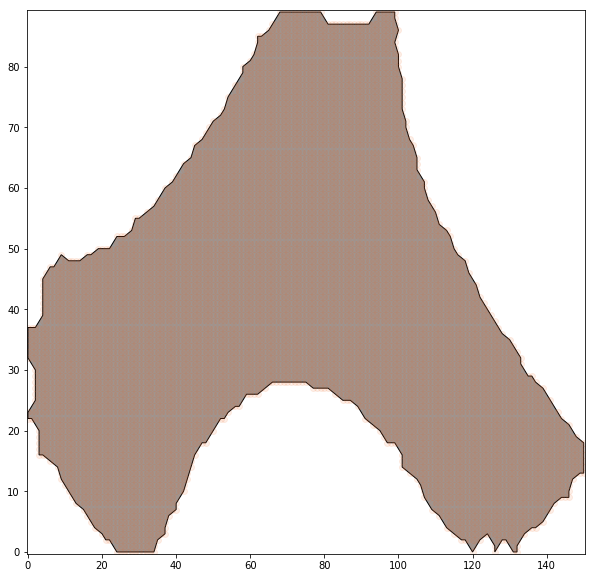

In [137]:
_ = plot_polygon(concave_hull)
_ = pl.plot(x,y,'o', color='#f16824', alpha=0.1)
pl.show()

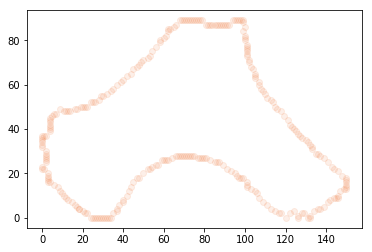

In [138]:
t = np.array(concave_hull.boundary.coords)
_ = pl.plot(t[:,0], t[:,1],'o', color='#f16824', alpha=0.1)

In [264]:
# function called .contains() that checks if a polygon contains a point
spts_out = geometry.Point(3.0000, 20.0)
spts_in  = geometry.Point(3.0001, 20.0)
print(concave_hull.contains(spts_out))
print(concave_hull.contains(spts_in))

False
True


In [265]:
# function called .within() that checks if a point is within a polygon
spts.within(concave_hull)
print(spts_out.within(concave_hull))
print(spts_in.within(concave_hull))

False
True


In [268]:
print(concave_hull.area)

7064.5


In [233]:
from scipy.interpolate import splprep, splev

tck, u = splprep(t.T, u=None, s=0.0, per=1) 
u_new = np.linspace(u.min(), u.max(), 1000)
x_new, y_new = splev(u_new, tck, der=0)

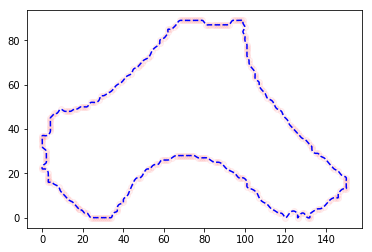

In [234]:
pl.figure()
pl.plot(t[:,0], t[:,1], 'ro', alpha=0.05)
pl.plot(x_new, y_new, 'b--')
pl.show()

In [235]:
from intersect import intersection

In [236]:
(cx, cy) = (70,10)
m = 0

In [237]:
# y = mx + b
b = cy - m*cx
xx = np.linspace(cx-90, cx+90, 100, endpoint=True)
yy = m*xx+b

In [238]:
xint, yint = intersection(t[:,0], t[:,1], xx, yy)

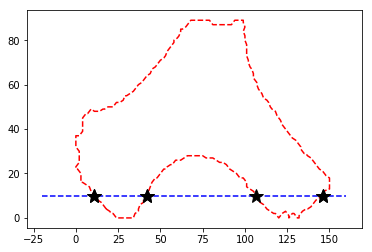

In [239]:
pl.figure()
pl.plot(t[:,0], t[:,1], 'r--')
pl.plot(xx, yy, 'b--')
pl.plot(xint, yint, '*k', markersize=15)
pl.show()

In [240]:
# TODO for grid MSD
# split line intersect in forward/backward to take max dist
# add tiny function to set line lenght from envelope?
# check center point isInside from polygon?
# angle to m

In [241]:
# TODO for simple stuff
# area, perimeter etc
# radius helper func

In [242]:
# length from points
def len_curve_pts(pts):
    # pts are Nx2
    # Assumes pts[0] is connected to pts[-1]
    tmp = pts[1:] - pts[:-1]
    dists = np.sqrt(tmp[:,0]**2+tmp[:,1]**2)
    # add last pts
    return dists.sum() + np.sqrt((pts[-1,0]-pts[0,0])**2+(pts[-1,1]-pts[0,1])**2)

In [243]:
len_t = len_curve_pts(t)
t_new = np.concatenate((x_new[:,None], y_new[:,None]), axis=1)
len_t_new = len_curve_pts(t_new)

In [244]:
print(len_t)
print(concave_hull.boundary.length)
print(len_t_new)

439.79425991589943
439.79425991589966
444.8575533957391


# MSD "ray" computation prototype

In [275]:
# get rough size limit for center sampling and line bounding 
x_min, y_min, x_max, y_max = point_collection.envelope.bounds

In [280]:
# grid the square at fixed resolution
resolution = 1 # pixel
x_range = np.arange(x_min-1, x_max+2, resolution)
y_range = np.arange(y_min-1, y_max+2, resolution)
X_grid, Y_grid = np.meshgrid(x_range, y_range)
# convert to list of shapely points
all_pts = [geometry.Point(x, y) for (x,y) in zip(X_grid.ravel(), Y_grid.ravel())]
# find all points inside the hull
valid_center = []
for pts in all_pts:
    if pts.within(concave_hull):
        valid_center.append(pts)

In [314]:
# test to define 1 "ray"
i = 400
# grab valid center
cx = valid_center[i].x
cy = valid_center[i].y
# define m from theta
theta = 30 # degrees from y=const and starting ++ quarant
m = np.tan(np.pi*theta/180)
# y = mx + b
b = cy - m*cx

In [315]:
# intersection both side

# one side
xx_1 = np.linspace(cx, x_max, 100, endpoint=True)
yy_1 = m*xx_1+b
xint1, yint1 = intersection(t[:,0], t[:,1], xx_1, yy_1)

# other side
xx_2 = np.linspace(x_min, cx, 100, endpoint=True)
yy_2 = m*xx_2+b
xint2, yint2 = intersection(t[:,0], t[:,1], xx_2, yy_2)

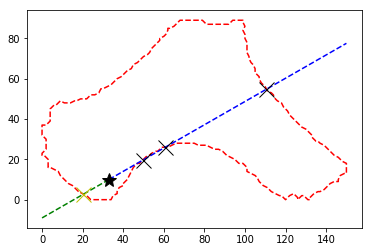

In [316]:
pl.figure()
pl.plot(t[:,0], t[:,1], 'r--')
pl.plot(xx_1, yy_1, 'b--')
pl.plot(xint1, yint1, 'xk', markersize=15)
pl.plot(xx_2, yy_2, 'g--')
pl.plot(xint2, yint2, 'xy', markersize=15)
pl.plot(cx, cy, '*k--', markersize=15)
pl.show()

In [321]:
indx1 = np.argmax((xint1 - cx)**2 + (yint1 - cy)**2)
pts_max1 = np.array([xint1[indx1], yint1[indx1]])

indx2 = np.argmax((xint2 - cx)**2 + (yint2 - cy)**2)
pts_max2 = np.array([xint2[indx2], yint2[indx2]])